# Mini-Project 2

## Task 1

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import math
pd.set_option('display.max_columns', None)

from sklearn.model_selection import cross_val_score, StratifiedKFold, GroupKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay
from joblib import dump
from joblib import load
from sklearn.ensemble import RandomForestClassifier

c:\Users\paul_\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Prepare Data

In [4]:
file = 'answerList_data.csv'
df_original = pd.read_csv(file)
df_original["Answer.option"] = np.where(df_original["Answer.option"] == "YES", 1, 0)
df_original["isCorrect"] = np.where(df_original["Answer.option"] == df_original["GroundTruth"], 1, 0)
df_original

,Answer.ID,FailingMethod,Question.ID,Answer.duration,Answer.confidence,Answer.difficulty,GroundTruth,TP,TN,FN,FP,Answer.option,Answer.order,Answer.explanation,Code.LOC,Code.complexity,Worker.ID,Worker.score,Worker.profession,Worker.yearsOfExperience,Worker.age,Worker.gender,Worker.whereLearnedToCode,Worker.country,Worker.programmingLanguage,isCorrect
0,261,HIT01_8,0,90.984,4,2,0,0,1,0,0,0,3,hoursOffset accepts negative numbers between -...,1,1,832cg-7G1i-462:73eI-8E-2g-985,5,Undergraduate_Student,7.0,21,Male,High School,United States,Java; C++; C#,1
1,262,HIT01_8,0,133.711,5,1,0,0,1,0,0,0,3,the conditional clause is correct for the give...,1,1,98ce7A-4i-507,4,Undergraduate_Student,10.0,25,Female,High School;University;Web,United States,c#,1
2,263,HIT01_8,0,77.696,5,2,0,0,1,0,0,0,3,The argument -2 is within the range (-23;23); ...,1,1,881AC0I2E-625:135cI3E-7e8-86,5,Professional_Developer,7.0,24,Male,High School;University;Web,United States,C++;Java;PHP,1
3,264,HIT01_8,0,46.644,1,1,0,0,1,0,0,0,3,The exception is in no way related to the hour...,1,1,270eG-5c6A3-46:65eI-2i-2I-9-36,5,Professional_Developer,20.0,38,Male,High School;University;Other On the job,USA,C#,1
4,265,HIT01_8,0,215.416,5,5,0,0,1,0,0,0,3,The issue cannot be with hoursOffset since the...,1,1,844Cg1g5e1-17:255ei-8G8E85-8,3,Undergraduate_Student,5.0,19,Male,High School;University;Web,United States,C++; Java,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2575,2316,HIT08_54,128,220.420,2,4,0,0,1,0,0,0,1,I don't believe this line would be the cause o...,1,1,1171ea-4g-6C-73-8,3,Graduate_Student,2.0,28,Male,University,USA,C#,1
2576,2317,HIT08_54,128,322.790,4,3,0,0,0,0,1,1,1,The line assumes that the string is a valid lo...,1,1,66AC-5a0g-47-9:1443IA-7C-6e967,5,Professional_Developer,17.0,39,Male,University;Web,USA,C#; VB.NET; Java,0
2577,2318,HIT08_54,128,159.530,5,1,0,0,1,0,0,0,1,This line is after all cases that throw the ex...,1,1,106iG8G-9I-9-80:590CG-6G-7i-71-9,4,Professional_Developer,10.0,31,Male,High School;University;Web;Other work,usa,C++,1
2578,2319,HIT08_54,128,68.578,5,1,0,0,1,0,0,0,1,The function never reaches this statement befo...,1,1,1221iC8A5A242:495CC9e6a691:11aE2c-4c-9-86,4,Undergraduate_Student,4.0,19,Male,University;Web;Other FIRST Robotics,United States,C++,1


In [5]:
def calculate_halstead_volume(text):
    tokens = str(text).lower().split()
    types = set(tokens)
    halstead_volume = len(tokens) * math.log2(len(types)) 
    return halstead_volume

df_original['Halstead_volume'] = df_original['Answer.explanation'].apply(calculate_halstead_volume)

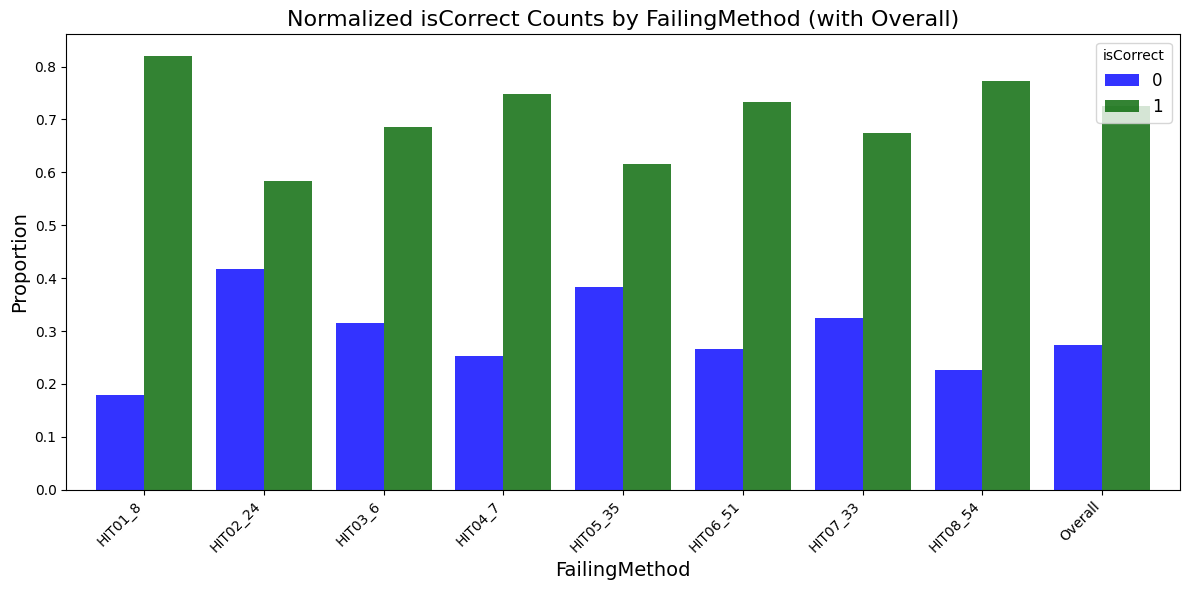

In [6]:
grouped_data = df_original.groupby("FailingMethod")["isCorrect"].value_counts(normalize=True).unstack()

overall = df_original["isCorrect"].value_counts(normalize=True)

grouped_data.loc["Overall"] = overall

grouped_data.plot(
    kind="bar",
    figsize=(12, 6),
    color=["blue", "darkgreen"],
    alpha=0.8,
    width=0.8
)

plt.title("Normalized isCorrect Counts by FailingMethod (with Overall)", fontsize=16)
plt.xlabel("FailingMethod", fontsize=14)
plt.ylabel("Proportion", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.legend(title="isCorrect", loc="upper right", fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()


In [6]:
churn_df = df_original.drop(["Worker.profession", 'Answer.ID', 'Question.ID', 'GroundTruth', 'TP', 'TN', 'FN', 'FP', 'Answer.option', 'Answer.order', 'Code.LOC', 'Code.complexity', 'Worker.ID', 'Worker.score','Answer.explanation', 'Worker.age', 'Worker.gender', 'Worker.whereLearnedToCode', 'Worker.country', 'Worker.programmingLanguage'], axis=1)
churn_df.head()

,FailingMethod,Answer.duration,Answer.confidence,Answer.difficulty,Worker.yearsOfExperience,isCorrect,Halstead_volume
0,HIT01_8,90.984,4,2,7.0,1,62.510250
1,HIT01_8,133.711,5,1,10.0,1,46.604513
2,HIT01_8,77.696,5,2,7.0,1,131.183297
3,HIT01_8,46.644,1,1,20.0,1,36.541209
4,HIT01_8,215.416,5,5,5.0,1,66.417140


### Define Holdout Set and Train Data

In [20]:
failing_methods = churn_df['FailingMethod'].unique()

holdout_methods = failing_methods[:2]
train_methods = failing_methods[2:]  


holdout_set = churn_df[churn_df['FailingMethod'].isin(holdout_methods)]
train_set = churn_df[churn_df['FailingMethod'].isin(train_methods)]


X_train = train_set.drop(columns=['isCorrect', 'FailingMethod'])
y_train = train_set['isCorrect']

X_holdout = holdout_set.drop(columns=['isCorrect', 'FailingMethod'])
y_holdout = holdout_set['isCorrect']


groups = train_set['FailingMethod']


rf = RandomForestClassifier(random_state=42)

param_grid = {'max_depth': [2,3,4,5,10,20,30,  None], 
             'min_samples_leaf': [1,2,3, 5, 10, 15, 30],
             'min_samples_split': [2,3,4,5],
             'max_features': [2,3,4,5],
             'n_estimators': [50, 75, 100, 125, 150, 200]
             }  

scoring = ['accuracy', 'precision', 'recall', 'f1']

group_kfold = GroupKFold(n_splits=5)


grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=group_kfold, 
                           scoring=scoring, refit="f1", n_jobs=-1, verbose=1)


grid_search.fit(X_train, y_train, groups=groups)


print(f"Best hyperparameters: {grid_search.best_params_}")

best_rf = grid_search.best_estimator_


Fitting 5 folds for each of 5376 candidates, totalling 26880 fits
Best hyperparameters: {'max_depth': 10, 'max_features': 2, 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 75}


In [80]:
dump(best_rf, 'best_rf_model.joblib')

['best_rf_model.joblib']

### Evaluate Model

In [22]:
def make_results(model_name, model_object):
    
    cv_results = pd.DataFrame(model_object.cv_results_)
    

    best_estimator_results = cv_results.iloc[cv_results['mean_test_f1'].idxmax(), :]

    f1 = best_estimator_results['mean_test_f1']
    recall = best_estimator_results['mean_test_recall']
    precision = best_estimator_results['mean_test_precision']
    accuracy = best_estimator_results['mean_test_accuracy']
    
    table = pd.DataFrame(
        {'model': [model_name],
         'precision': [precision],
         'recall': [recall],
         'F1': [f1],
         'accuracy': [accuracy],
        }
    )

    return table

results = make_results('RandomForest', grid_search)
print(results)

          model  precision    recall        F1  accuracy
0  RandomForest   0.720867  0.993728  0.834633  0.719412


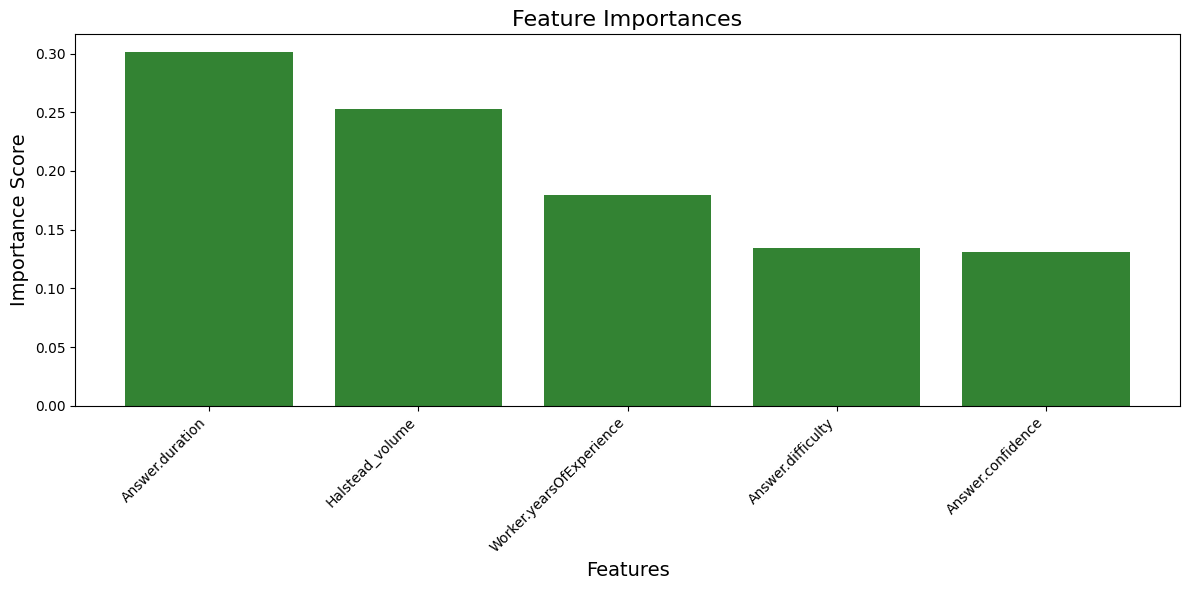

In [26]:

importances =best_rf.feature_importances_
feature_names =  X_train.columns
sorted_indices = np.argsort(importances)[::-1]

sorted_feature_names = feature_names[sorted_indices]

plt.figure(figsize=(12, 6))
plt.bar(sorted_feature_names, importances[sorted_indices], color="darkgreen", alpha=0.8)
plt.title("Feature Importances", fontsize=16)
plt.xlabel("Features", fontsize=14)
plt.ylabel("Importance Score", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

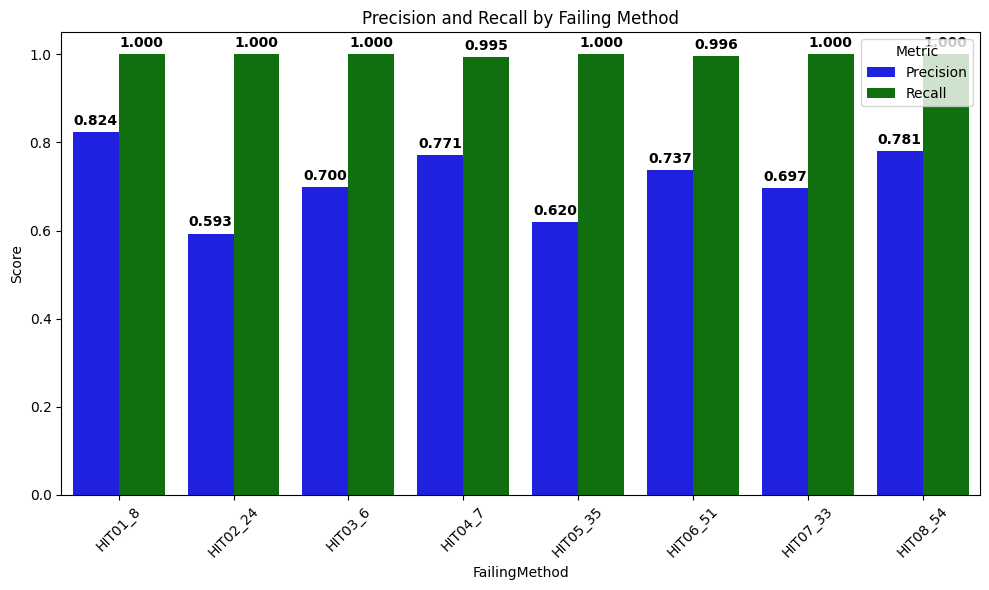

In [70]:
recall_scores= []
precision_scores= []
for method in churn_df['FailingMethod'].unique():
    method_data = churn_df[churn_df['FailingMethod'] == method]
    X_method = method_data.drop(columns=['isCorrect', 'FailingMethod'])
    y_method = method_data['isCorrect']

    y_pred = best_rf.predict(X_method)
    
    precision = precision_score(y_method, y_pred, average='binary', zero_division=0)
    recall = recall_score(y_method, y_pred, average='binary', zero_division=0)
    
    recall_scores.append(recall)
    precision_scores.append(precision)

metrics_df = pd.DataFrame({
    'FailingMethod': churn_df['FailingMethod'].unique(),
    'Precision': precision_scores,
    'Recall': recall_scores
})

metrics_df_melted = metrics_df.melt(id_vars=['FailingMethod'], 
                                     value_vars=['Precision', 'Recall'],
                                     var_name='Metric', value_name='Score')

metrics_df_melted['FailingMethod'] = metrics_df_melted['FailingMethod'].astype('category')

color_palette = ['blue', 'green']

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='FailingMethod', y='Score', hue='Metric', data=metrics_df_melted, palette=color_palette)

for p in ax.patches:
    ax.annotate(f'{p.get_height():.3f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()),  
                ha='center', va='center', fontsize=10, color='black', fontweight='bold', 
                xytext=(0, 8), textcoords='offset points')  

plt.title('Precision and Recall by Failing Method')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [82]:
prediction_df = df_original.copy()


X_original = prediction_df.drop(columns=['isCorrect', 'FailingMethod', "Worker.profession", 'Answer.ID', 'Question.ID', 'GroundTruth', 'TP', 'TN', 'FN', 'FP', 'Answer.option', 'Answer.order', 'Code.LOC', 'Code.complexity', 'Worker.ID', 'Worker.score','Answer.explanation', 'Worker.age', 'Worker.gender', 'Worker.whereLearnedToCode', 'Worker.country', 'Worker.programmingLanguage'])
y_original = prediction_df['isCorrect']
y_pred_original = best_rf.predict(X_original)

prediction_df['predicted_isCorrect'] = y_pred_original


filtered_df = prediction_df[
    (prediction_df['GroundTruth'] == 1) & 
    (prediction_df['FailingMethod'].isin(holdout_methods))
]
filtered_df['is_correct_prediction'] = (filtered_df['predicted_isCorrect'] == filtered_df['isCorrect']).astype(int)

filtered_df['Answer.explanation_size'] = filtered_df['Answer.explanation'].apply(len)

filtered_df

C:\Users\paul_\AppData\Local\Temp\ipykernel_11896\4000179112.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['is_correct_prediction'] = (filtered_df['predicted_isCorrect'] == filtered_df['isCorrect']).astype(int)
C:\Users\paul_\AppData\Local\Temp\ipykernel_11896\4000179112.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Answer.explanation_size'] = filtered_df['Answer.explanation'].apply(len)


,Answer.ID,FailingMethod,Question.ID,Answer.duration,Answer.confidence,Answer.difficulty,GroundTruth,TP,TN,FN,FP,Answer.option,Answer.order,Answer.explanation,Code.LOC,Code.complexity,Worker.ID,Worker.score,Worker.profession,Worker.yearsOfExperience,Worker.age,Worker.gender,Worker.whereLearnedToCode,Worker.country,Worker.programmingLanguage,isCorrect,Halstead_volume,predicted_isCorrect,is_correct_prediction,Answer.explanation_size
20,441,HIT01_8,1,140.407,4,3,1,1,0,0,0,1,3,Minutes are set to -15; which is less then 0 a...,1,1,35Eg-6i-8G-2-6-8,3,Undergraduate_Student,3.0,49,Female,University,US,php,1,64.000000,1,1,80
21,442,HIT01_8,1,77.018,5,1,1,0,0,1,0,0,3,The code never gets that far. The problem is a...,1,1,27Ei-8i0A-3-59:15cG-7i7C996,3,Professional_Developer,23.0,44,Male,High School;University,USA,RPG; Visual Basic,0,255.452549,1,0,309
22,443,HIT01_8,1,112.409,5,2,1,1,0,0,0,1,3,In the code there is a check that 0 <= minutes...,1,1,286Ig-9C0E170,5,Undergraduate_Student,5.0,20,Male,University;Web,USA,c#,1,137.891738,1,1,149
23,444,HIT01_8,1,76.418,5,1,1,1,0,0,0,1,3,There is a logical check for if minuteOffset i...,1,1,1221iC8A5A242:495CC9e6a691:11aE2c-4c-9-86,4,Undergraduate_Student,4.0,19,Male,University;Web;Other FIRST Robotics,United States,C++,1,149.028003,1,1,164
24,445,HIT01_8,1,261.928,5,2,1,1,0,0,0,1,3,YES. The issue is on line 279 (as I explained ...,1,1,555aC0a8e4-8-3:535CE8A-5e-95-2,3,Graduate_Student,1.0,25,Female,University,USA,java,1,620.945337,1,1,550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,96,HIT02_24,14,252.020,4,4,1,1,0,0,0,1,2,public class IllegalArgumentException extends ...,1,1,892CA6a-8c802:759GA-8a-5a-285,4,Professional_Developer,6.0,31,Female,University;Web,INDIA,PHP;MySQL,1,136.312752,1,1,300
296,97,HIT02_24,14,228.137,3,3,1,0,0,1,0,0,2,"It looks like the variable ""g"" is being proper...",1,1,963eA7C5A9-8-1,5,Undergraduate_Student,8.0,20,Male,High School;University;Web,United States,Java; C#,0,100.078200,1,0,121
297,98,HIT02_24,14,26.055,4,5,1,0,0,1,0,0,2,no there is no issue.,1,1,830gA-8i-9I517,5,Professional_Developer,6.0,26,Male,University,india,java,0,10.000000,1,0,21
298,99,HIT02_24,14,80.907,0,2,1,0,0,1,0,0,2,FFFFFFFFFFFDS FFFFFFFFFFFFF,1,1,1029gC9I4C-463,5,Undergraduate_Student,2.0,24,Male,High School;University,India,java; c; c++,0,2.000000,1,0,27


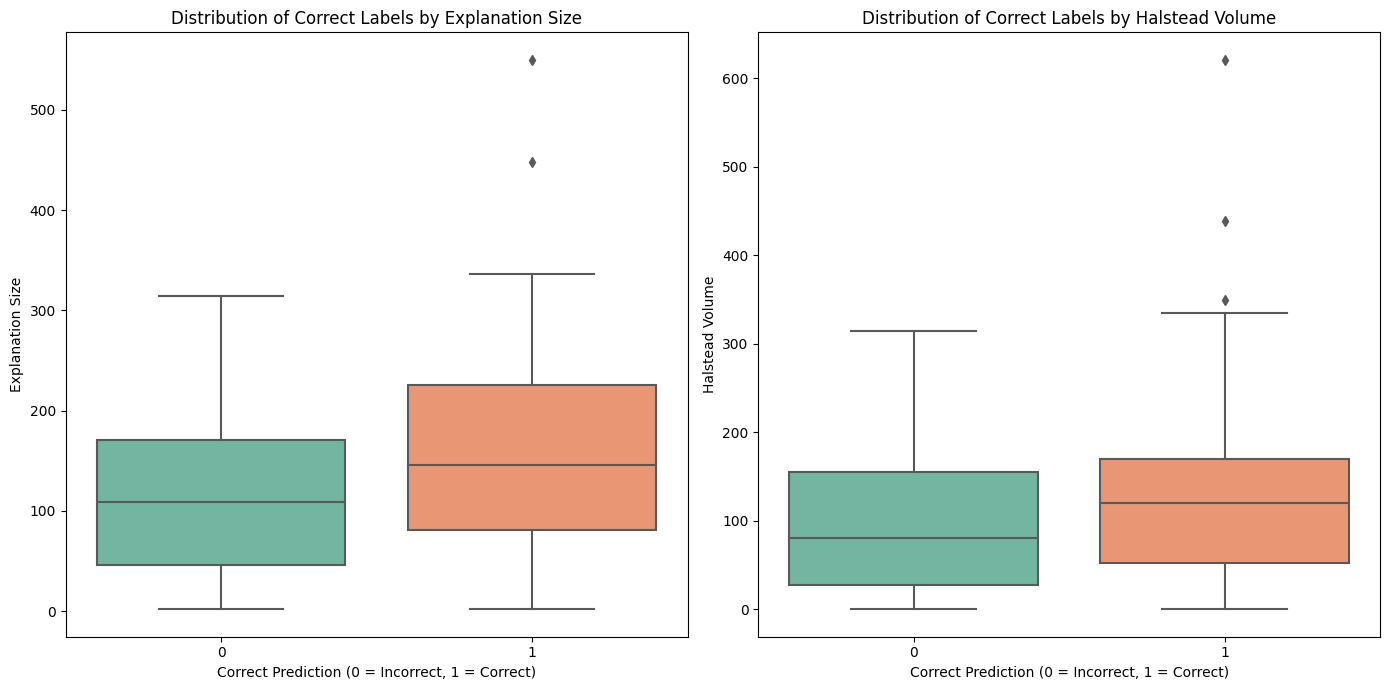

In [83]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

sns.boxplot(x='is_correct_prediction', y='Answer.explanation_size', data=filtered_df, ax=axes[0], palette="Set2")
axes[0].set_title('Distribution of Correct Labels by Explanation Size')
axes[0].set_xlabel('Correct Prediction (0 = Incorrect, 1 = Correct)')
axes[0].set_ylabel('Explanation Size')

sns.boxplot(x='is_correct_prediction', y='Halstead_volume', data=filtered_df, ax=axes[1], palette="Set2")
axes[1].set_title('Distribution of Correct Labels by Halstead Volume')
axes[1].set_xlabel('Correct Prediction (0 = Incorrect, 1 = Correct)')
axes[1].set_ylabel('Halstead Volume')

plt.tight_layout()
plt.show()

In [85]:
final_df = filtered_df[filtered_df['is_correct_prediction'] == 1]
final_df

,Answer.ID,FailingMethod,Question.ID,Answer.duration,Answer.confidence,Answer.difficulty,GroundTruth,TP,TN,FN,FP,Answer.option,Answer.order,Answer.explanation,Code.LOC,Code.complexity,Worker.ID,Worker.score,Worker.profession,Worker.yearsOfExperience,Worker.age,Worker.gender,Worker.whereLearnedToCode,Worker.country,Worker.programmingLanguage,isCorrect,Halstead_volume,predicted_isCorrect,is_correct_prediction,Answer.explanation_size
20,441,HIT01_8,1,140.407,4,3,1,1,0,0,0,1,3,Minutes are set to -15; which is less then 0 a...,1,1,35Eg-6i-8G-2-6-8,3,Undergraduate_Student,3.0,49,Female,University,US,php,1,64.000000,1,1,80
22,443,HIT01_8,1,112.409,5,2,1,1,0,0,0,1,3,In the code there is a check that 0 <= minutes...,1,1,286Ig-9C0E170,5,Undergraduate_Student,5.0,20,Male,University;Web,USA,c#,1,137.891738,1,1,149
23,444,HIT01_8,1,76.418,5,1,1,1,0,0,0,1,3,There is a logical check for if minuteOffset i...,1,1,1221iC8A5A242:495CC9e6a691:11aE2c-4c-9-86,4,Undergraduate_Student,4.0,19,Male,University;Web;Other FIRST Robotics,United States,C++,1,149.028003,1,1,164
24,445,HIT01_8,1,261.928,5,2,1,1,0,0,0,1,3,YES. The issue is on line 279 (as I explained ...,1,1,555aC0a8e4-8-3:535CE8A-5e-95-2,3,Graduate_Student,1.0,25,Female,University,USA,java,1,620.945337,1,1,550
25,446,HIT01_8,1,236.045,5,1,1,1,0,0,0,1,3,"The variable ""minutesOffset"" is checked incorr...",1,1,815aA-9g-4e44-8:182Ae3g-6i-30-5,5,Professional_Developer,5.0,29,Male,University;Other On the job,USA,Python; SQL; Java,1,165.171354,1,1,233
27,448,HIT01_8,1,259.790,3,3,1,1,0,0,0,1,3,This variable contains a value of -15 as set b...,1,1,78cA-9e4a2-6-7,5,Hobbyist,1.0,30,Female,University,united states,none,1,211.966925,1,1,229
28,449,HIT01_8,1,230.142,4,3,1,1,0,0,0,1,3,Yes; the variable gets set to -15 through the ...,1,1,1449GA0I-4C14-1,4,Undergraduate_Student,4.0,35,Male,High School,USA,php and C++,1,287.592032,1,1,284
29,450,HIT01_8,1,253.302,4,2,1,1,0,0,0,1,2,As noted in the comments; valid input for minu...,1,1,41eI0e3i-806:568Ae7g8c-7-1-2,5,Hobbyist,4.0,35,Male,University;Web;Other MOOC,USA,Java Python,1,349.939098,1,1,328
30,451,HIT01_8,1,89.521,4,3,1,1,0,0,0,1,2,"the variable should be defined as ""unsigned in...",1,1,1523iA8C4C-602,5,Professional_Developer,14.0,34,Male,High School;University;Web;Other books,Russia,C++;Object Pascal,1,62.510250,1,1,86
34,455,HIT01_8,1,161.419,4,4,1,1,0,0,0,1,2,The value of minutes offset does not have vali...,1,1,1573Ic-9c3a-7-13,5,Graduate_Student,2.0,24,Male,University,India,c; c++,1,114.200253,1,1,144


In [86]:
#export final_df to csv
final_df.to_csv('final_df.csv', index=False)

In [3]:
#load best_rf_model
best_rf = load('best_rf_model.joblib')

# get the params of best_rf
best_rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 2,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 10,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 75,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}